# Weekly demand prediction

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import gc
import os
import importlib

import pandas as pd
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import utils


datapath = os.path.join('data')
cal_filename = 'calendar.csv'    # input
stv_filename = 'sales_train_validation.csv'    # input
ss_filename = 'sample_submission.csv'    # output
sellp_filename = 'sell_prices.csv'    # input
ste_filename = 'sales_train_evaluation.csv'

cal_raw = pd.read_csv(os.path.join(datapath, cal_filename))
stv_raw = pd.read_csv(os.path.join(datapath, stv_filename))
sellp_raw = pd.read_csv(os.path.join(datapath, sellp_filename))
# Not necessary for prototype test
# ss = pd.read_csv(os.path.join(datapath, ss_filename))
# ste = pd.read_csv(os.path.join(datapath, ste_filename))

cal_raw = utils.reduce_mem_usage(cal_raw)
stv_raw = utils.reduce_mem_usage(stv_raw)
sellp_raw = utils.reduce_mem_usage(sellp_raw)
# ss = utils.reduce_mem_usage(ss)
# ste = utils.reduce_mem_usage(ste)

sales_raw = stv_raw
sales_raw['id'] = sales_raw['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))    # remove _validation or _evaluation

d_cols = [c for c in sales_raw.columns if 'd_' in c]    # sales data columns
level_cols = sales_raw.columns[sales_raw.columns.str.contains("d_")==False].values    # level columns

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [2]:
'''
Preprosessing features on calendar
wm_yr_wk: 
    the format is: yyy-nw
    yyy stands for the number of the year starting from 1900(as for 2011, this would be 2011 - 1900 = 111)
    nw stands for the number of the week of this year
'''
#### Calendar data-type changing
cal = cal_raw.assign(d=cal_raw.d.str[2:].astype(int))
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1


In [3]:
'''
sell prices
    sell_price per a week for a certain item.
'''
sellp_raw.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [4]:
sales_raw.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## Extract items based on **Price-Sales correlation**

In [5]:
'''
Preprocessing features on sales
There are 30,490 unique id
    id: item_id + store_id
    e.g. HOBBIES_1_001 + CA_1
Melting sales_raw
    
'''
sales = sales_raw.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                       var_name="d", value_name="demand")
sales = sales.assign(d=sales.d.str[2:].astype("int16"))

#### Merge by 'd' and 'wm_yr_wk'
sales = sales.merge(cal, how="left", on="d")    # calendar is daily-based 
sales = sales.merge(sellp_raw, how="left", on=["wm_yr_wk", "store_id", "item_id"])    # sell_prices is weekly-based
sales = sales.dropna(axis=0, subset=['id', 'd', 'date', 'wm_yr_wk', 'demand', 'sell_price'])

sales_summary = sales.loc[:, ['id', 'd', 'date', 'wm_yr_wk', 'demand', 'sell_price']]
sales_summary = sales_summary.dropna(axis=0)

sales.head()    # (46,027,957, 22)
sales_summary.head()    # (46,027,957, 6)

,id,d,date,wm_yr_wk,demand,sell_price
7,HOBBIES_1_008_CA_1,1,2011-01-29,11101,12,0.459961
8,HOBBIES_1_009_CA_1,1,2011-01-29,11101,2,1.559570
9,HOBBIES_1_010_CA_1,1,2011-01-29,11101,0,3.169922
11,HOBBIES_1_012_CA_1,1,2011-01-29,11101,0,5.980469
14,HOBBIES_1_015_CA_1,1,2011-01-29,11101,4,0.700195


In [215]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,1968,NaN,NaN,NaN,NaN,0,0,0


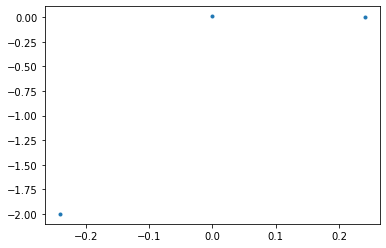

In [218]:
# a = df_price_sales.loc['FOODS_1_001_WI_3'].to_numpy()
# a = df_abs_price_sales.loc['FOODS_1_001_WI_1'].to_numpy()
a = df_diff_price_sales.loc[item_id].to_numpy()

# plt.plot(a[:,0], '.')
plt.plot(a[:,0], a[:,1], '.')

In [142]:
a = df_diff_price_sales.groupby('id').apply(lambda x: (x['diff_week_price'].shape[0], x['diff_week_demand'].shape[0]))

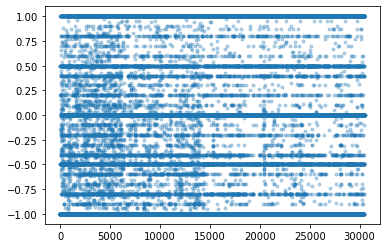

In [175]:
# plt.plot(df_corr['diff_corr_s'].to_numpy(), '.', alpha=0.3)
plt.plot(df_corr['abs_corr_s'].to_numpy(), '.', alpha=0.3)

In [245]:
'''
Weekly aggregation + Price-wise aggregation
'''
d = {}
d['week_sell_price'] = sales_summary.groupby(['id', 'wm_yr_wk'])['sell_price'].mean()
d['week_sum_demand'] = sales_summary.groupby(['id', 'wm_yr_wk'])['demand'].sum()
d['diff_week_price'] = d['week_sell_price'].groupby(['id']).diff().fillna(0)
d['diff_week_demand'] = d['week_sum_demand'].groupby(['id']).diff().fillna(0)

df_price_sales = pd.DataFrame(d, dtype='float32')    # (6,597,201, 2)


#### Weekly aggregation
grouped = df_price_sales.groupby('id')
d = {}
d['abs_corr'] = grouped.apply(lambda x: stats.linregress(x['week_sell_price'], x['week_sum_demand'])[2])    # correlation
d['abs_corr_p'] = grouped.apply(lambda x: stats.pearsonr(x['week_sell_price'], x['week_sum_demand'])[0])    # Pearson correlation
d['abs_corr_s'] = grouped.apply(lambda x: stats.spearmanr(x['week_sell_price'], x['week_sum_demand'])[0])    # Spearman correlation

d['diff_corr'] = grouped.apply(lambda x: stats.linregress(x['diff_week_price'], x['diff_week_demand'])[2])    # correlation
d['diff_corr_p'] = grouped.apply(lambda x: stats.pearsonr(x['diff_week_price'], x['diff_week_demand'])[0])    # Pearson correlation
d['diff_corr_s'] = grouped.apply(lambda x: stats.spearmanr(x['diff_week_price'], x['diff_week_demand'])[0])    # Spearman correlation

# df_corr = pd.DataFrame(d)    # 30,490 items' correlation



#### Aggregation sales per a same price
df_abs_price_sales = pd.DataFrame(df_price_sales.groupby(['id', 'week_sell_price'])['week_sum_demand'].mean(), dtype='float32')
df_abs_price_sales.reset_index(level='week_sell_price', inplace=True)

grouped = df_abs_price_sales.groupby('id')
d['agg_abs_corr'] = grouped.apply(lambda x: stats.linregress(x['week_sell_price'], x['week_sum_demand'])[2])    # correlation
d['agg_abs_corr_p'] = grouped.apply(lambda x: stats.pearsonr(x['week_sell_price'], x['week_sum_demand'])[0] if x['week_sell_price'].shape[0]>1 else 0)    # Pearson correlation
d['agg_abs_corr_s'] = grouped.apply(lambda x: stats.spearmanr(x['week_sell_price'], x['week_sum_demand'])[0] if x['week_sell_price'].shape[0]>1 else 0)    # Spearman correlation


df_diff_price_sales = pd.DataFrame(df_price_sales.groupby(['id', 'diff_week_price'])['diff_week_demand'].mean(), dtype='float32')
df_diff_price_sales.reset_index(level='diff_week_price', inplace=True)

grouped = df_diff_price_sales.groupby('id')
d['agg_diff_corr'] = grouped.apply(lambda x: stats.linregress(x['diff_week_price'], x['diff_week_demand'])[2])    # correlation
d['agg_diff_corr_p'] = grouped.apply(lambda x: stats.pearsonr(x['diff_week_price'], x['diff_week_demand'])[0] if x['diff_week_price'].shape[0]>1 else 0)    # Pearson correlation
d['agg_diff_corr_s'] = grouped.apply(lambda x: stats.spearmanr(x['diff_week_price'], x['diff_week_demand'])[0] if x['diff_week_price'].shape[0]>1 else 0)    # Spearman correlation

df_corr = pd.DataFrame(d)    # 30,490 items' correlation

In [265]:
corr_selected_ids = {}
corr_selected_ids["<-0.1"] = df_corr[df_corr['diff_corr_s'] < -0.1].index    # 2626
corr_selected_ids["<-0.2"] = df_corr[df_corr['diff_corr_s'] < -0.2].index    # 175
corr_selected_ids["<-0.3"] = df_corr[df_corr['diff_corr_s'] < -0.3].index    # 15
corr_selected_ids[">0.1"] = df_corr[df_corr['diff_corr_s'] > 0.1].index    # 2690
corr_selected_ids[">0.2"] = df_corr[df_corr['diff_corr_s'] > 0.2].index    # 164
corr_selected_ids[">0.3"] = df_corr[df_corr['diff_corr_s'] > 0.3].index    # 15
corr_selected_ids["=0.0"] = df_corr[df_corr['diff_corr_s'] == 0.0].index    # 460

In [1]:
from scipy import stats

item_id = 'FOODS_3_003_CA_1'
tmp = df_price_sales.loc[item_id]
# x, y = tmp['week_sell_price'], tmp['week_sum_demand']
x, y = tmp['diff_week_price'], tmp['diff_week_demand']
regs = stats.linregress(x, y)

plt.figure(0, figsize=(10,7))
# plt.scatter(x, y, marker='o', s0, label='original data', alpha=0.3)
plt.plot(x, y, 'o', ms=20, alpha=0.3)
plt.plot(x, regs[0]*x + regs[1], 'r', label='fitted line (r={:.2f})'.format(regs[2]))
plt.title('Item ID: {}'.format(item_id), fontsize=20)
# plt.xlabel('Weekly abs. price', fontsize=20)
# plt.ylabel('Weekly aggregated sales', fontsize=20)
plt.xlabel('Weekly diff. price', fontsize=20)
plt.ylabel('Weekly aggregated sales', fontsize=20)

plt.legend(fontsize=20)

NameError: name 'df_price_sales' is not defined

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

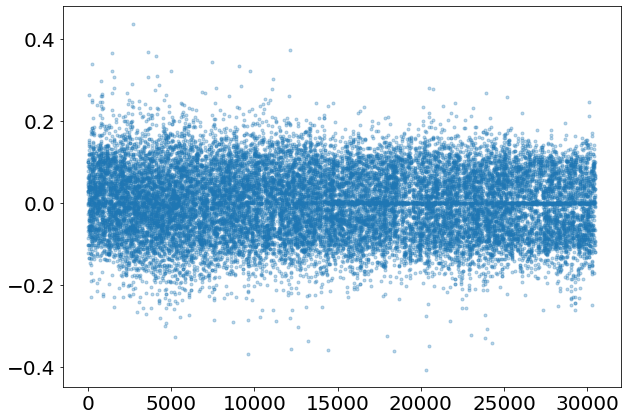

In [368]:
plt.figure(0, figsize=(10,7))
plt.plot(df_corr['diff_corr_s'].to_numpy(), '.', alpha=0.3)
# plt.plot(df_corr['abs_corr_s'].to_numpy(), '.', alpha=0.3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
item_id = 'FOODS_1_002_CA_2'
sampled_df = df_price_sales.loc[item_id]

# fig, axs = plt.subplots(2, 1, figsize=(10,16))
# axs[0].plot(sampled_df['week_sell_price'], 'o', ms=20, alpha=0.3)
# axs[0].set_title('{}'.format(item_id), fontsize=20)
# axs[0].set_xlabel('Week ID', fontsize=20)
# axs[0].set_ylabel('Weekly abs. price', fontsize=20)

# axs[1].plot(sampled_df['week_sell_price'], sampled_df['week_sum_demand'], 'o', ms=20, alpha=0.3)
# axs[1].set_title('{}'.format(item_id), fontsize=20)
# axs[1].set_xlabel('Weekly abs. price', fontsize=20)
# axs[1].set_ylabel('Weekly aggregated sales', fontsize=20)


fig, axs = plt.subplots(2, 1, figsize=(10,16))
axs[0].plot(sampled_df['diff_week_price'], 'o', ms=20, alpha=0.3)
axs[0].set_title('{}'.format(item_id), fontsize=20)
axs[0].set_xlabel('Week ID', fontsize=20)
axs[0].set_ylabel('Weekly diff. price', fontsize=20)

axs[1].plot(sampled_df['diff_week_price'], sampled_df['diff_week_demand'], 'o', ms=20, alpha=0.3)
axs[1].set_title('{}'.format(item_id), fontsize=20)
axs[1].set_xlabel('Weekly diff. price', fontsize=20)
axs[1].set_ylabel('Weekly aggregated sales', fontsize=20)

In [224]:
df_abs_price_sales.loc[item_id]

,week_sell_price,week_sum_demand
id,,
FOODS_1_002_CA_2,7.878906,1.241379
FOODS_1_002_CA_2,8.882812,5.125000
FOODS_1_002_CA_2,9.476562,4.812500


In [ ]:
item_id = 'FOODS_1_001_WI_1'

a = df_abs_price_sales.loc[item_id].to_numpy()
b = df_diff_price_sales.loc[item_id].to_numpy()

fig, axs = plt.subplots(2, 1, figsize=(10,16))
axs[0].plot(a[:,0], a[:,1], 'o', ms=20)
axs[0].set_title('{}'.format(item_id), fontsize=20)
axs[0].set_xlabel('Week ID', fontsize=20)
axs[0].set_ylabel('Weekly abs. price', fontsize=20)

axs[1].plot(b[:,0], b[:,1], 'o', ms=20)
axs[1].set_title('{}'.format(item_id), fontsize=20)
axs[1].set_xlabel('Weekly diff. price', fontsize=20)
axs[1].set_ylabel('Mean of weekly sum sales', fontsize=20)

## Feature engineering

In [296]:
'''
Categorical features to ordinal encoding
These features are daily-based features.
'''
cal = pd.read_csv(os.path.join(datapath, cal_filename))
cal = utils.reduce_mem_usage(cal)

cal = utils.categorize_calendar(cal)
print('unique features in wady: ', cal['wday'].unique())
print('unique features in month: ', cal['month'].unique())
# print('unique features in event_name_1: ', cal['event_name_1'].unique())
cal.head()

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to  0.03 Mb (84.4% reduction)
unique features in wady:  [0 1 2 3 4 5 6]
unique features in month:  [ 0  1  2  3  4  5  6  7  8  9 10 11]


,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


In [297]:
'''
Preprosessing and add derived features on selling prices
This is weekly-based feature set.
'''
sellp_raw = pd.read_csv(os.path.join(datapath, sellp_filename))
sellp_raw = utils.reduce_mem_usage(sellp_raw)

sellp = utils.prep_selling_prices(sellp_raw)
sellp.head()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 182.68 Mb (0.0% reduction)


,store_id,item_id,wm_yr_wk,sell_price,diff_week_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,CA_1,HOBBIES_1_001,11325,9.578125,0.000000,NaN,NaN,0.0
1,CA_1,HOBBIES_1_001,11326,9.578125,0.000000,0.000000,NaN,0.0
2,CA_1,HOBBIES_1_001,11327,8.257812,-1.320312,-0.137695,NaN,0.0
3,CA_1,HOBBIES_1_001,11328,8.257812,0.000000,0.000000,NaN,0.0
4,CA_1,HOBBIES_1_001,11329,8.257812,0.000000,0.000000,NaN,0.0


In [278]:
'''
Preprosessing and add derived features on sales 
'''
stv = pd.read_csv(os.path.join(datapath, stv_filename))
stv = utils.reduce_mem_usage(stv)

sales = stv
sales['id'] = sales['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))    # remove _validation or _evaluation

Mem. usage decreased to 95.00 Mb (78.7% reduction)


In [361]:
'''
Preprosessing and add derived features on sales
'''
corr_threshold = 0.3
if corr_threshold < 0:
    selected_ids = corr_selected_ids['<{}'.format(corr_threshold)]
elif corr_threshold > 0:
    selected_ids = corr_selected_ids['>{}'.format(corr_threshold)]
print("# of selected_ids: {}".format(selected_ids.shape[0]))
selected_sales = sales[sales['id'].isin(selected_ids)]    # select some items following a rule

# sales = utils.reshape_sales(sales, drop_d=1000)    # d_1 to d_drop_d are dropped.
selected_sales = selected_sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                                     var_name='d', value_name='demand')
selected_sales = selected_sales.assign(d=selected_sales.d.str[2:].astype("int16"))
print('reshaping is done')

selected_sales = utils.prep_sales(selected_sales)    # daily based features
print('preprocessing is done')
selected_sales.head()

# of selected_ids: 15
reshaping is done
Mem. usage decreased to  1.83 Mb (39.5% reduction)
preprocessing is done


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
3105,FOODS_2_198_CA_2,FOODS_2_198,FOODS_2,FOODS,CA_2,CA,208,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3106,FOODS_2_283_CA_2,FOODS_2_283,FOODS_2,FOODS,CA_2,CA,208,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3107,FOODS_2_145_CA_3,FOODS_2_145,FOODS_2,FOODS,CA_3,CA,208,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3108,FOODS_3_134_CA_3,FOODS_3_134,FOODS_3,FOODS,CA_3,CA,208,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3109,FOODS_3_362_CA_3,FOODS_3_362,FOODS_3,FOODS,CA_3,CA,208,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [362]:
#### Merge by 'd' and 'wm_yr_wk'
selected_sales = selected_sales.merge(cal, how="left", on="d")
selected_sales = selected_sales.merge(sellp, how="left", on=["wm_yr_wk", "store_id", "item_id"])    # weekly features are copied 7 times to daily features

sales_summary = selected_sales.loc[:, ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wm_yr_wk',
                                       'demand', 
                                       'sell_price', 'diff_week_price', 'sell_price_rel_diff', 'sell_price_roll_sd7', 'sell_price_cumrel',    # this comes from sell_price
                                       'lag_t28', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_std_t7', 'rolling_std_t30']]
sales_summary = sales_summary.dropna(subset=['sell_price'])

In [363]:
group_cols = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wm_yr_wk']
dense_cols = ['sell_price', 'diff_week_price', 'sell_price_rel_diff', 'sell_price_roll_sd7', 'sell_price_cumrel',
              'lag_t28', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 
              'rolling_mean_t90', 'rolling_mean_t180', 'rolling_std_t7', 'rolling_std_t30']
week_dense_cols = []
d = {}
for col_name in dense_cols:
    if col_name == 'diff_week_price':
        d[col_name] = sales_summary.groupby(group_cols)[col_name].mean()    # daily to weekly aggregation
        week_dense_cols.append(col_name)
    else:
        d['week_'+col_name] = sales_summary.groupby(group_cols)[col_name].mean()    # daily to weekly aggregation
        week_dense_cols.append('week_'+col_name)
    
d['week_sum_demand'] = sales_summary.groupby(group_cols)['demand'].sum()    # target column
d['diff_week_demand'] = d['week_sum_demand'].diff().fillna(0)

df_price_sales = pd.DataFrame(d, dtype='float32')

df_input = df_price_sales.reset_index()
df_input = df_input.dropna(axis=0)
df_input = df_input.reset_index(drop=True)

df_input = df_input[df_input['wm_yr_wk']<11613]    # remove the last week (as this comes from not full 7 days)

In [364]:
'''
Ordinal encoding of remaining categoricals
'''
from sklearn.preprocessing import OrdinalEncoder

# cat_cols = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
cat_cols = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']

# In loop to minimize memory use
for v in cat_cols:
    df_input[v] = OrdinalEncoder(dtype="int").fit_transform(df_input[[v]])

In [365]:
# weekly_filename = 'week_price_demand_corr{}.csv'.format(corr_threshold)
weekly_filename = 'week_diff_price_demand_corr{}.csv'.format(corr_threshold)
print(weekly_filename)

df_input.to_csv(os.path.join(datapath, weekly_filename))

df_input['id'].unique()

week_diff_price_demand_corr0.3.csv


array(['FOODS_1_022_WI_3', 'FOODS_1_148_WI_2', 'FOODS_1_148_WI_3',
       'FOODS_1_159_CA_4', 'FOODS_2_057_WI_2', 'FOODS_2_145_CA_3',
       'FOODS_2_147_TX_2', 'FOODS_2_192_TX_1', 'FOODS_2_198_CA_2',
       'FOODS_2_283_CA_2', 'FOODS_3_134_CA_3', 'FOODS_3_296_WI_3',
       'FOODS_3_362_CA_3', 'FOODS_3_500_TX_1', 'FOODS_3_602_CA_3'],
      dtype=object)

In [367]:
df_input

,id,item_id,dept_id,store_id,cat_id,state_id,wm_yr_wk,week_sell_price,diff_week_price,week_sell_price_rel_diff,...,week_lag_t28,week_rolling_mean_t7,week_rolling_mean_t30,week_rolling_mean_t60,week_rolling_mean_t90,week_rolling_mean_t180,week_rolling_std_t7,week_rolling_std_t30,week_sum_demand,diff_week_demand
0,FOODS_1_022_WI_3,0,0,6,0,2,11329,6.031250,0.000000,0.000000,...,0.000000,0.244873,0.233276,0.116638,0.077759,0.038879,0.647949,0.728027,0.0,0.0
1,FOODS_1_022_WI_3,0,0,6,0,2,11330,6.031250,0.000000,0.000000,...,0.000000,0.000000,0.233276,0.116638,0.077759,0.038879,0.000000,0.728027,1.0,1.0
2,FOODS_1_022_WI_3,0,0,6,0,2,11331,6.031250,0.000000,0.000000,...,0.000000,0.000000,0.218994,0.116638,0.077759,0.038879,0.000000,0.696289,0.0,-1.0
3,FOODS_1_022_WI_3,0,0,6,0,2,11332,6.031250,0.000000,0.000000,...,0.000000,0.000000,0.076172,0.116638,0.077759,0.038879,0.000000,0.385498,0.0,0.0
4,FOODS_1_022_WI_3,0,0,6,0,2,11333,6.031250,0.000000,0.000000,...,0.000000,0.000000,0.009521,0.116638,0.077759,0.038879,0.000000,0.052185,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,FOODS_3_602_CA_3,13,2,1,0,0,11608,2.679688,0.679688,0.339844,...,0.142822,0.040802,0.076172,0.104736,0.092041,0.534668,0.107971,0.268311,6.0,6.0
1257,FOODS_3_602_CA_3,13,2,1,0,0,11609,2.679688,0.000000,0.000000,...,0.000000,0.101990,0.066650,0.104736,0.099976,0.539062,0.270020,0.253662,20.0,14.0
1258,FOODS_3_602_CA_3,13,2,1,0,0,11610,2.679688,0.000000,0.000000,...,0.000000,0.000000,0.038086,0.085693,0.099976,0.500000,0.000000,0.192749,13.0,-7.0
1259,FOODS_3_602_CA_3,13,2,1,0,0,11611,2.679688,0.000000,0.000000,...,0.000000,0.000000,0.033325,0.061890,0.090454,0.427002,0.000000,0.182617,8.0,-5.0


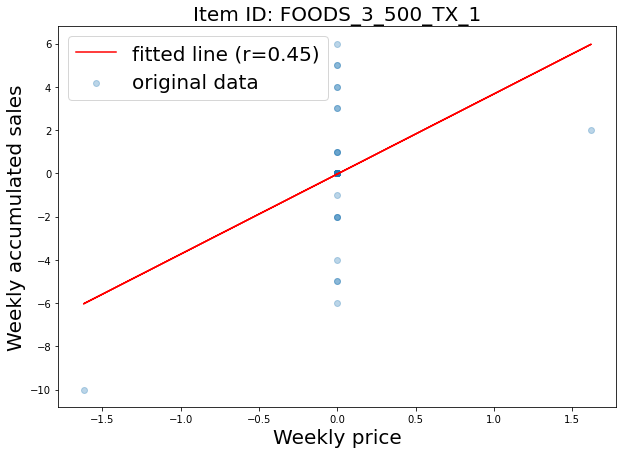

In [372]:
from scipy import stats

# full_id = 'FOODS_1_012_CA_1'
full_id = 'FOODS_3_500_TX_1'
# full_id = 'FOODS_1_056_TX_1'
tmp = df_input[df_input['id']==full_id]
# x, y = tmp['week_sell_price'], tmp['week_sum_demand']
x, y = tmp['diff_week_price'], tmp['diff_week_demand']
regs = stats.linregress(x, y)

plt.figure(0, figsize=(10,7))
plt.scatter(x, y, marker='o', label='original data', alpha=0.3)
plt.plot(x, regs[0]*x + regs[1], 'r', label='fitted line (r={:.2f})'.format(regs[2]))
plt.title('Item ID: {}'.format(full_id), fontsize=20)
plt.xlabel('Weekly price', fontsize=20)
plt.ylabel('Weekly accumulated sales', fontsize=20)
plt.legend(fontsize=20)

In [371]:
df_input['id'].unique(), corr_threshold

(array(['FOODS_1_022_WI_3', 'FOODS_1_148_WI_2', 'FOODS_1_148_WI_3',
        'FOODS_1_159_CA_4', 'FOODS_2_057_WI_2', 'FOODS_2_145_CA_3',
        'FOODS_2_147_TX_2', 'FOODS_2_192_TX_1', 'FOODS_2_198_CA_2',
        'FOODS_2_283_CA_2', 'FOODS_3_134_CA_3', 'FOODS_3_296_WI_3',
        'FOODS_3_362_CA_3', 'FOODS_3_500_TX_1', 'FOODS_3_602_CA_3'],
       dtype=object),
 0.3)